In [35]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from scipy.stats import entropy
from sklearn.utils import Bunch
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import figure
from matplotlib.pyplot import *
from numpy import linspace
from random import sample
import pandas as pd 
import numpy as np

In [109]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

## Exploring Data

In [3]:
print("\n".join(ng5_train.data[0].split("\n")))


I'd be willing to make two wagers:
1) Snow doesn't win ROY.
2) Mattingly is out of baseball within five years.

I'm skeptical of the first, because I don't think Snow is that good a
player, and he is on a losing team.

I'm skeptical of the second because of his back.  Mattingly is 32 this
year, and how many players play until they are 40?  Not too many, and
most of them didn't have chronic back problems when they were 32.

Could be wrong on either or both, but I think that's the smart way to
bet...


In [4]:
print(ng5_train.target_names[ng5_train.target[0]])

rec.sport.baseball


## Third step : Select n samples from non labeled data U

In [36]:
## Create a pipeline to make it simpler
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [107]:
## Create a pipeline to make it simpler
text_clf_svm = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='log', penalty='l2',
                           alpha=1e-5,random_state=42,
                           max_iter=5, tol=None)),
])

# Start the loop process

In [7]:
# Define function which updates datasets
def update(seed, unlabeled, ind):
     seed.data = seed.data + [unlabeled.data[i] for i in ind]
     seed.target = np.append(seed.target,unlabeled.target[ind])
     unlabeled.data = [unlabeled.data[i] for i in range(len(unlabeled.data)) if i not in ind]
     unlabeled.target = np.delete(unlabeled.target, ind)
     return seed, unlabeled

In [38]:
def update_accuracy(seed, unlabeled, accuracy, classifier):
     global test
     # Train the clasifier
     classifier.fit(seed.data, seed.target)
     # predicted classes and corresponding probabilities
     predicted_proba = classifier.predict_proba(unlabeled.data)
     # check the real accuracy on test data
     predicted = classifier.predict(test.data)
     accuracy.append(np.mean(predicted == test.target))
     return accuracy, predicted_proba 

In [21]:
def active_learner(train, test, classifier, initial_size, n):

    length = len(train.data)
    seed_uncert = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_margin = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_entropy = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_rand = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    unlabeled_uncert = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_margin = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_entropy = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_rand = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])

    accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = [], [], [], []
    
    # Start the loop
    while len(unlabeled_uncert.data) > 0:
         ## Least Confidence (aka. Uncertainty) Strategy
         accuracy_uncert, predicted_proba = update_accuracy(seed_uncert, unlabeled_uncert, accuracy_uncert, classifier)
         uncertainty = 1 - predicted_proba.max(axis=1)
         ## Margin Sampling
         accuracy_margin, predicted_proba = update_accuracy(seed_margin, unlabeled_margin, accuracy_margin, classifier)
         part = np.partition(-predicted_proba, 1, axis=1)
         margin = - part[:, 0] + part[:, 1]
         ## Entropy based
         accuracy_entropy, predicted_proba = update_accuracy(seed_entropy, unlabeled_entropy, accuracy_entropy, classifier)
         entr = entropy(predicted_proba.T)
         ## Random
         accuracy_rand, predicted_proba = update_accuracy(seed_rand, unlabeled_rand, accuracy_rand, classifier)

         if len(unlabeled_uncert.data) > n : 
              # index of top n uncertainty score
              ind_uncert = np.argpartition(uncertainty, -n)[-n:]
              # index of n min margin score
              ind_margin = np.argpartition(margin, n)[:n]
              # index of top n entropy score
              ind_entropy = np.argpartition(entr, -n)[-n:]
              # ind random
              ind_rand = sample([i for i in range(len(unlabeled_rand.data)-1)], n)

              seed_uncert, unlabeled_uncert = update(seed_uncert, unlabeled_uncert, ind_uncert)
              seed_margin, unlabeled_margin = update(seed_margin, unlabeled_margin, ind_margin)
              seed_entropy, unlabeled_entropy = update(seed_entropy, unlabeled_entropy, ind_entropy)
              seed_rand, unlabeled_rand = update(seed_rand, unlabeled_rand, ind_rand)

         else :
              # seed.data = seed.data + unlabeled.data
              # seed.target = np.append(seed.target, unlabeled.target)
              # text_clf.fit(seed.data, seed.target)
              unlabeled_uncert.data = unlabeled_margin = unlabeled_entropy = unlabeled_rand = []
    return accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand

In [110]:
accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = active_learner(train, test, text_clf, 500, 80)
accuracy_uncert_svm, accuracy_margin_svm, accuracy_entropy_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 500, 80)

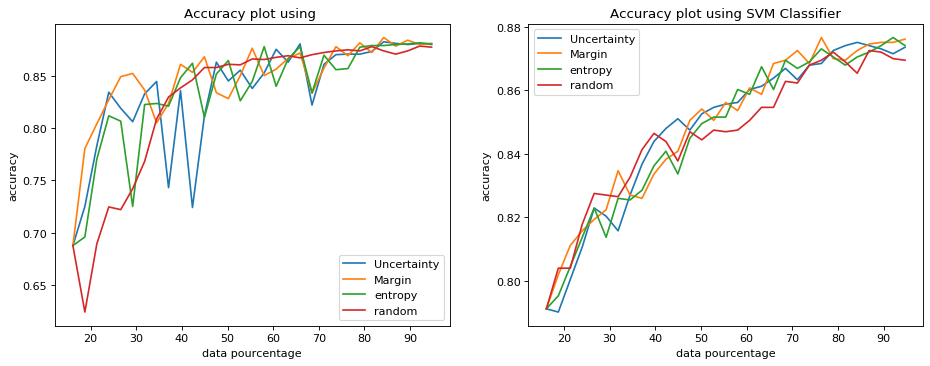

In [111]:
figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(accuracy_uncert), accuracy_uncert)
plot(x/len(accuracy_uncert), accuracy_margin)
plot(x/len(accuracy_uncert), accuracy_entropy)
plot(x/len(accuracy_uncert), accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using ')

## Plot accuracy plot using SVM Classifier

subplot(1, 2, 2)
plot(x/len(accuracy_uncert_svm), accuracy_uncert_svm)
plot(x/len(accuracy_uncert_svm), accuracy_margin_svm)
plot(x/len(accuracy_uncert_svm), accuracy_entropy_svm)
plot(x/len(accuracy_uncert_svm), accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier')

show()

# Test with another Dataset

The second dataset we used is 
https://www.kaggle.com/himselfthedecker/facens-nlp-corpus-categorias-treino

In [80]:
data = pd.read_csv("corpus_categorias_treino.csv", sep=',', engine='python')
data = data[['words','category']]
data = data.sample(frac=1)
data.head()

,words,category
4047,If because of this incident they become angry ...,science_fiction
838,Rankin sneered at him .,adventure
2112,"Ah , you were splendid '' .",adventure
7560,"The two Governments will , upon the request of...",government
3655,"Ernie offered , taking the pint of sweet lucy ...",adventure


In [81]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
train = Bunch(data= train.words.values.tolist(), target=train.category.values)
test = data[~msk]
test = Bunch(data= test.words.values.tolist(), target=test.category.values)

In [83]:
accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = active_learner(train, test, text_clf, 750, 120)
accuracy_uncert_svm, accuracy_margin_svm, accuracy_entropy_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 750, 120)

In [105]:
accuracy_uncert_svm, accuracy_margin_svm, accuracy_entropy_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 750, 150)

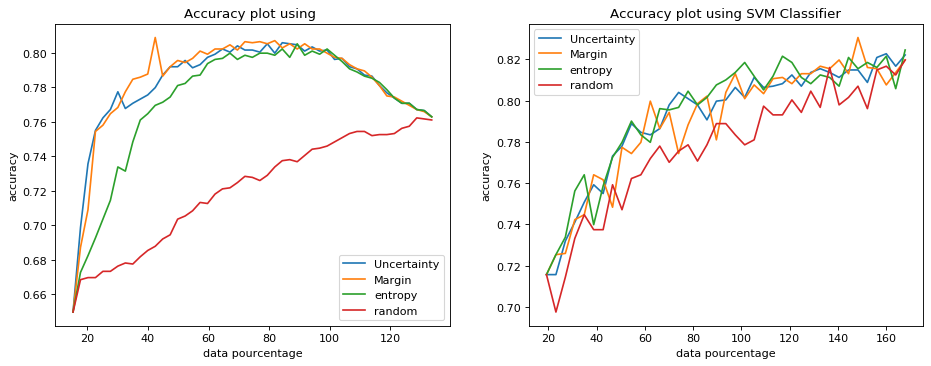

In [106]:
figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(750, len(train.data), len(accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(accuracy_uncert), accuracy_uncert)
plot(x/len(accuracy_uncert), accuracy_margin)
plot(x/len(accuracy_uncert), accuracy_entropy)
plot(x/len(accuracy_uncert), accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using ')

## Plot accuracy plot using SVM Classifier
x = linspace(750, len(train.data), len(accuracy_uncert_svm))

subplot(1, 2, 2)
plot(x/len(accuracy_uncert_svm), accuracy_uncert_svm)
plot(x/len(accuracy_uncert_svm), accuracy_margin_svm)
plot(x/len(accuracy_uncert_svm), accuracy_entropy_svm)
plot(x/len(accuracy_uncert_svm), accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier')

show()